# **Homework 2**

In this Homework, people who collaborated on all excercises are:


*   Danilo Guglielmi (s318083)
*   Maria Francesca Merangolo (s318905)
*   Gabriele Martina (s310789)

**Problem 1.** Studying a single particle performing a continuous-time random walk

The main goal of the first part of this exercise is to simulate the behaviour of a particle in a continuous time Markov chain, speifically a simple random walk on a Graph. It is useful to understand the connections between random walks and flow dynamics.

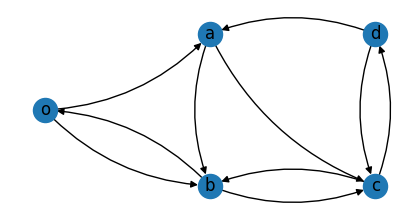

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import choice, rand

# Graph definition
G = nx.DiGraph()
G.add_nodes_from(['o','a','b','c','d'])
G.add_edges_from([('o', 'a'), ('o', 'b'),
                  ('a', 'b'), ('a', 'c'),
                  ('b', 'o'), ('b', 'c'),
                  ('c', 'b'), ('c', 'd'),
                  ('d', 'a'), ('d', 'c')])

# Draw nodes with labels
pos = {'o': (0,0), 'a': (1,1), 'b': (1,-1), 'c': (2,-1), 'd':(2,1)}
plt.figure(figsize=(4, 2))
nx.draw(G, pos, with_labels=True, connectionstyle='arc3, rad = 0.2')
# we use rad to adjust the curvature of the edges
# greater rad, greater the curvature of the edges

plt.show()

In [2]:
# We map all nodes
map = {'o': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4}

We have a graph $G =(\mathcal X, \Lambda)$ with nodes $\mathcal X$ and weight matrix $\Lambda$ describing possible transitions between nodes.
To simulate the random walk we use the first approach to model CTMC.

1. We define a unique **global** Poisson clock with an appropriate rate $\omega^* = \max_i(\omega_i)$ where $\omega_i= \sum_j \Lambda_{ij}$
2. when we are at node $i$ and **the global clock ticks**, either we jump to a neighbor $j$ with probability $\bar P_{ij} = \frac{\Lambda_{ij}}{\omega_{*}}, \; i \neq j$ or we stay in the same node (no transition) with probability $\bar P_{ii} = 1 - \sum_{i \neq j} \bar P_{ij}$.

In this approach, the continuous time is discretized using a global clock, while the matrix Q describes the jumps. For this reason the matrix $\bar P$ is called **jump chain** of the CTMC.



**(a) What is, according to the simulations, the average time it takes a particle that starts in node $b$ to leave the node and then return to it?**

In [3]:
# Transition rate matrix
Lambda = [
          [0, 2/5, 1/5, 0, 0],
          [0, 0, 3/4, 1/4, 0],
          [1/2, 0, 0, 1/3, 0],
          [0, 0, 1/3, 0, 2/3],
          [0, 1/3, 0, 1/3, 0],
]

w = np.sum(Lambda, axis=1)
w_star = np.max(w)

# Compute the off-diagonal part of Q
P_bar = Lambda/w_star
# Add the diagonal part
P_bar = P_bar + np.diag(np.ones(len(w))-np.sum(P_bar,axis=1))

# Compute dominant eigenvector
values,vectors = np.linalg.eig(P_bar.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
#print("\npi_bar=", pi_bar)

nstates = len(pi_bar)

The aim is to compute the average return time, so we simulate random walks on $G$ several times, starting at node $b$ and stopping when it returns to $b$.
At every $t_{next}$, we extract the next node of the path randomly, according to the probabilities stored in the row of $\bar P$ corresponding to the current state. At the end, we make the average of all different return times.

**Remark 1**: We apply a second condition to the random walk. The graph $G$ has not a self-loop on node $b$, so we discard any paths {$b$, $b$}.

**Remark 2**:
To simulate a Poisson clock with rate $r$, one must simulate the time between two consecutive ticks, which we denote by $t_{next}$. We can compute $t_{next}$ as

$$ t_{next} = - \frac{\ln(u)}{r}$$

where $u$ is a random variable with uniform distribution, $u \in \mathcal{U}(0,1)$.

In [4]:
# The function simulates a random walk on a directed graph and
# computes the time it takes for a particle to leave and return to
# a specified node

def random_walk(start_node, end_node, P_bar, w_star, is_ret_time):

  # Set the number of steps in the simulation
  n_steps = 10000

  # time will keep trace of the times for each simulation
  # We can have float time, so dtype = float
  time = np.zeros(n_steps, dtype=float)

  for i in range(n_steps):

      # For each simulation, we initialize pos list with the starting node,
      # the transition_times with the initial time set to 0,
      # and the counter to 0
      pos = []
      pos.append(start_node) # we start from origin node (in this case b)

      # transition_times will store the time instants at which jumps/transitions
      #happen
      transition_times = []
      transition_times.append(0)

      node_counter = 0
      next_node = start_node
      # The random time to wait for the next transition
      # is drawn according to its distribution
      # In the formula for t_next we use w_star, the rate of the "global"
      # Poisson clock
      t_next = -np.log(rand()) / w_star

      # loop for the random walk until reaching the destination
      while True:
        node_counter += 1

        # The next node to visit will be extracted according to the probabilities
        # stored in the row of P_bar corresponding to the current state.
        # Paths 'b'->'b' are not valid, because the particle never leaves the
        # node so "is_ret_time" helps us in order to do this
        if is_ret_time == True and node_counter == 1:
          while next_node == start_node:
            next_node = choice(nstates, p=P_bar[pos[node_counter - 1],:])
        else:
            next_node = choice(nstates, p=P_bar[pos[node_counter - 1],:])

        pos.append(next_node)
        transition_times.append(transition_times[node_counter - 1] + t_next)

        # Check if the walk has returned to the starting node
        # if so, end the walk
        if next_node == end_node:
            break

        # generate the random time for the next transition
        t_next = -np.log(rand()) / w_star

      # store the return time for the current simulation
      time[i] = transition_times[-1]

  average_return_time = np.sum(time)/len(time)

  return average_return_time

In [5]:
start_node = map['b']
end_node = map['b']
average_time = random_walk(start_node, end_node, P_bar, w_star, True)

print("Average time from node b and return to node b:", average_time, "s")


Average time from node b and return to node b: 4.411432461105327 s


**(b) How does the result in (a) compare to the theoretical return-time $ \mathbb{E}_b[T_b^+] $?**

We can compare the result in (a) with the theoretical return time as:
$$ \mathbb{E}_b[T_b^+] =
\frac{1}{ω_b \bar{\pi}_b}
$$ where
$$T_b^+ = min \{t≥1 | X(t) = b \} $$
and $\pi$ represents the stazionary probability vector.

We use this formula because we are working in continuous time.

In [6]:
time_theoretical = 1 / (w[map['b']]*pi_bar[map['b']])
print("Theoretical return time: ", time_theoretical, "s")

Theoretical return time:  4.599999999999998 s


It is necessary to consider that during the simulations, the time to wait for the next transition is random. Therefore, the results produced by the simulation and the theoretical law are close but not equal.

**(c) What is, according to the simulations, the average time it takes to move from node $o$ to node $d$?**

Here, the goal is to compute the average hitting time $\mathbb{E}_o[T_d]$ of a particle in $G$, which has different starting node and destination.
We reuse the random walk function, only modifying the starting and ending nodes.

**Remark:** In this context, it is not necessary to check the additional condition on the path used in the previous point.

In [7]:
start_node = map['o']
end_node = map['d']

average_time = random_walk(start_node, end_node, P_bar, w_star, False)

print("Average time from node o to node d:", average_time, "s")

Average time from node o to node d: 10.7864264606895 s


**(d) How does the result in (c) compare to the theoretical hitting-time $\mathbb{E}_o[T_d]$?**

We can compare the result in (c) with the theoretical hitting time as:

$$
\mathbb{E}_i[T_S] =
\frac{1}{ω_i}
+ \sum_{j} P_{ij} \mathbb{E}_j[T_S], \quad \forall i \in R= \mathcal V \setminus \mathcal S
$$
for the set $$S = \{d\}$$.

The expected hitting times  $\hat{x}= (\mathbb{E}_i[T_S])_{i \in R}$ for the set $S$ and for all nodes $i \in R = V \setminus S$ can be computed by solving the system of equations

$$
\hat{x} = \mathbf{1} + \hat{P}\hat{x},
$$

where $\hat{P}$ is obtained from $P$ (the normalized weight matrix of the graph) by removing the rows and columns corresponding to the nodes in the set $S$.

More explicitly, the expected hitting times can be expressed as

$$
\hat{x} = (I - \hat{P})^{-1} \mathbf{1}
$$


**Remark**: note that $(I - \hat{P})$ is invertible only if $V \setminus S$ has at least a link pointing to $S$. Indeed, if $(I - \hat{P})$ is not invertible, the random walk starting from nodes in $V \setminus S$ cannot hit nodes in $S$, and the hitting times diverge.

In [8]:
n_nodes = G.number_of_nodes()

# Define the set S and the remaining nodes R
S = [map['d']]
R = [node for node in range(n_nodes) if node not in S]

# Restrict P to R x R to obtain hat(P)
hatP = P_bar[np.ix_(R, R)]
# solve the linear system to obtain hat(x)
# np.linalg.solve solves a linear matrix equation given
# the coefficient matrix and the dependent variable values
hatx = np.linalg.solve((np.identity(n_nodes-len(S))-hatP),np.ones(n_nodes-len(S)))
# define the hitting times to the set S
# hitting time is 0 if the starting node is in S
hitting_s = np.zeros(n_nodes)

# hitting time is hat(x) for nodes in R
for r in R:
    hitting_s[r] = hatx[r]

print("Hitting Time:", hitting_s[0], "s")

Hitting Time: 10.766666666666666 s


As in the previous point, the results produced by the simulation and the theoretical law are close but not equal.

**(e) Interpret the matrix $Λ$ as the weight matrix of a graph $G = (V, E, Λ)$, and simulate the French-DeGroot dynamics on $G$ with an arbitrary initial condition $x(0)$. Does the dynamics converge to a consensus state for every initial condition $x(0)$? Motivate your answer.**

In this part, our attentions is moved to the opinion dynamics $x(t)$.
To study this problem, we use the French-DeGroot dynamic on $G = (V, E, Λ)$ with arbitrary initial conditions.

**Remark**: Now $Λ$ is considered as weight matrix.

In [9]:
# We add the weight to the graph G
for i, edge in enumerate(G.edges):
   source_index = map[edge[0]]
   target_index = map[edge[1]]
   G[edge[0]][edge[1]]['weight'] = Lambda[source_index][target_index]

# Check if the graph is strongly connected
print("Is the graph strongly connected?", nx.is_strongly_connected(G))

# Check if the graph is aperiodic
print("Is the graph aperiodic?", nx.is_aperiodic(G))

Is the graph strongly connected? True
Is the graph aperiodic? True


The dynamics of $x(t)$ reads
$x(t+1) = Px(t)$,
where $P$ is the normalized adjacency matrix.
We know that the dynamic converges to the consensus state if the graph is strongly connected and if it is aperiodic. Therefore, we need to verify these conditions.

 # Experiment  1 

Initial conditions: [0.44864849 0.11267369 0.71733988 0.24463166 0.87736491] 

Final opinions: [0.47782479 0.47776028 0.47801618 0.47753043 0.47809422] 

The consensus value is: 0.4778379285347664 



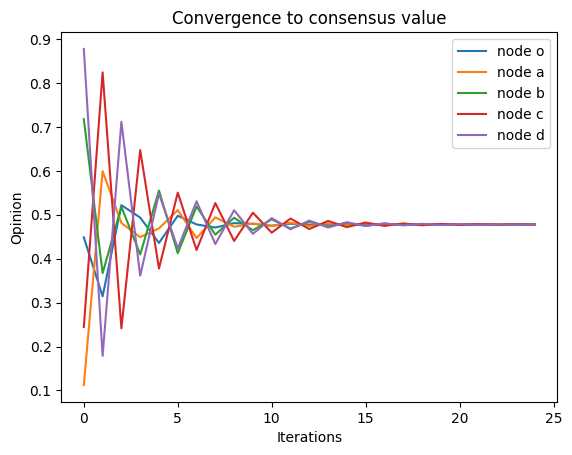

 # Experiment  2 

Initial conditions: [0.45504295 0.04893632 0.64121969 0.97806471 0.39779442] 

Final opinions: [0.54208726 0.54211452 0.54199927 0.5422446  0.54194998] 

The consensus value is: 0.5420837895226316 



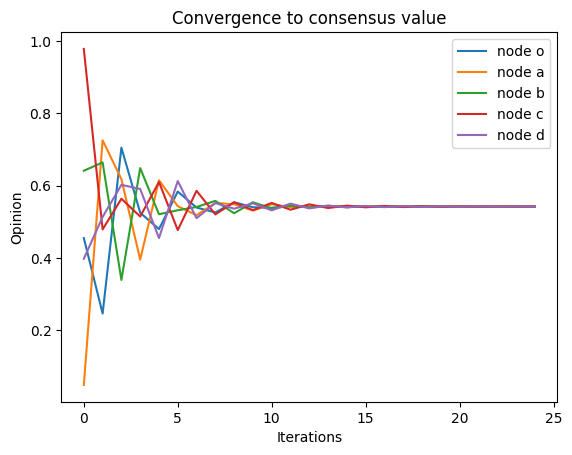

 # Experiment  3 

Initial conditions: [0.37049967 0.48225116 0.88765992 0.55576009 0.32402446] 

Final opinions: [0.56596078 0.56595392 0.56600787 0.56590704 0.56601764] 

The consensus value is: 0.5659685377554826 



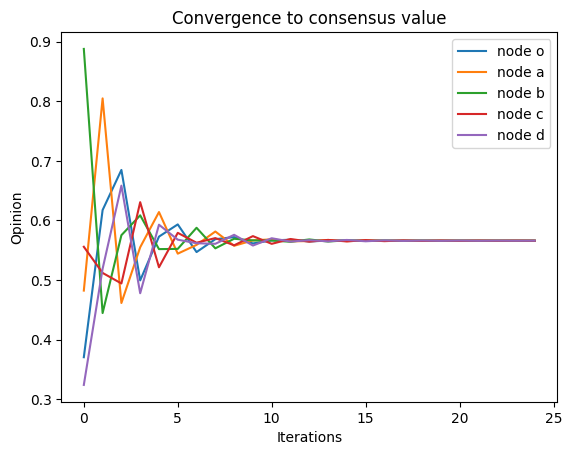

 # Experiment  4 

Initial conditions: [0.49807552 0.11008119 0.04797293 0.70433724 0.49252916] 

Final opinions: [0.3520219  0.35205385 0.35189253 0.35221625 0.35184046] 

The consensus value is: 0.35200990381257147 



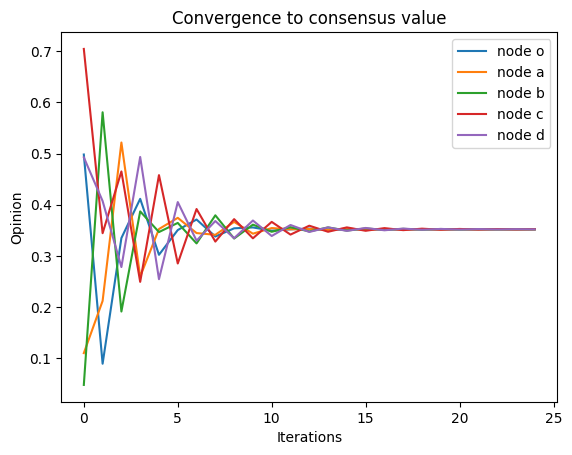

 # Experiment  5 

Initial conditions: [0.22477606 0.31741675 0.3680041  0.71527433 0.40645172] 

Final opinions: [0.42158448 0.42160185 0.42153538 0.4216677  0.42151096] 

The consensus value is: 0.42158236269697114 



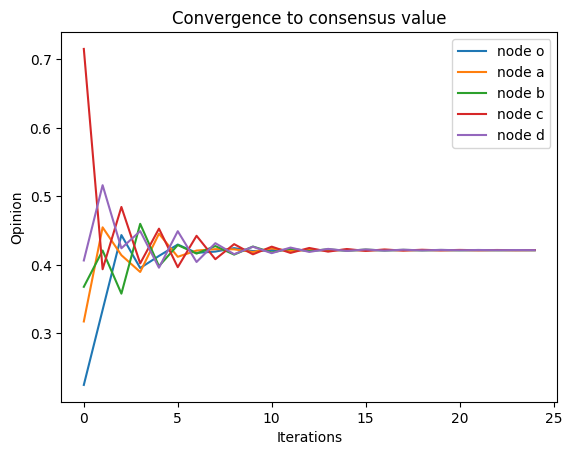

In [10]:
# P matrix
A = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
A = A.toarray() # convert A to a numpy array
degrees = np.sum(A,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ A

n_iter = 25 # number of iterations among nodes
n_times = 5 # number of simulations for every input

labels = {node: node for node in G.nodes()}  # to create labels for the plot

for i in range(n_times):
  # Set the initial condition for the dynamics
  x = np.zeros((n_nodes,n_iter))

  # Input
  u = np.random.rand(n_nodes)
  # u = 10*np.random.rand(n_nodes)
  # u = 50*np.random.rand(n_nodes)
  # u = 100*np.random.rand(n_nodes)

  x[:,0] = u;
  x0 = x[:,0]
  print(" # Experiment ",i+1,"\n")
  print("Initial conditions:", x0, "\n")

  # Evolve the opinion vector
  for t in range(1,n_iter):
    x[:,t] = P @ x[:,t-1]
  x_final = x[:,n_iter-1]
  print("Final opinions:", x_final, "\n")

  w,v = np.linalg.eig(P.T)
  # selects the eigenvalue 1 and print the eigenvector
  for index in [i for i in range(len(G)) if np.isclose(w[i],1)]:
    pi = v[:,index].real  # -> eigenvectors are complex but pi is real,
                          #    so we convert it to real
    pi = pi/np.sum(pi)

  # The asymptotic behaviour of dynamics is linked with initial conditions x0
  # with the following law: pi.T @ x (French-De Groot model)
  print("The consensus value is:", pi.T @ x0, "\n")

  # plot to see if we reach a consensus
  for node in range(G.number_of_nodes()):
      trajectory = x[node,:]
      plt.plot(trajectory, label='node {0:s}'.format(list(G.nodes())[node]))

  plt.legend()
  plt.title("Convergence to consensus value")
  plt.xlabel('Iterations')
  plt.ylabel('Opinion')
  plt.show()

Since the graph is strongly connected and aperiodic, all opinions converge to a common value. So $x(t)$ converges to a consensus status for every initial condition $x(0)$.

**(f)** Assume that the initial state of the dynamics for each node $i \in V$ is given by $x_i(0) = \xi_{i}$ , where ${\xi_{i}}_{i \in V}$ are independent random variables with variance:
$ \quad σ_a^2 = σ_b^2 = σ_c^2 = 1, \quad σ_o^2=σ_d^2 =2$

**Compute the variance of the consensus value, and compare your results with numerical simulations.**



The theoretical value of the variance is given by
$
\sigma^2 = \sum_{i} \sigma^2_i \pi_i^2
$.

To compare the results with numerical simulation, we conduct 200 simulations using the `np.random.normal` command to generate samples from a normal (Gaussian) distribution. In particular, we utilize the `scale` parameter
to specify the standard deviation of the distribution. Since variance is the square of the standard deviation, we need to use the square root of the specified variances. Therefore, `scale=np.sqrt(variance)` sets the standard deviation of the normal distribution for each state variable according to the specified variances.

In [11]:
w,v = np.linalg.eig(P.T)

# Select the eigenvalue 1 and print the eigenvector
for index in [i for i in range(len(G)) if np.isclose(w[i],1)]:
    pi = v[:,index].real  # -> eigenvectors are complex but pi is real,
                          # so we convert it to real
    pi = pi/np.sum(pi)

# Set the variances
variance = np.array([2, 1, 1, 1, 2])

print("Variance of the consensus value:", np.sum(variance*(pi**2)))

# Start with random initial states and run the dynamics 200 times
# Store in alfa_err the consensus values at each run
alfa_err = np.zeros(200)

for i in range(200):
    # x0
    x = np.random.normal(scale=np.sqrt(variance), size=len(variance))
    for n in range(500):
        x = P @ x
    alfa_err[i] = (np.mean(x))*(np.mean(x))

print("Variance of the numerical simulation:", np.mean(alfa_err))


Variance of the consensus value: 0.2593491124260356
Variance of the numerical simulation: 0.2544368405659161


The results are very close but not equal because the value of the variance of the consensus is also influenced by the opinion of the other nodes.

**(g)** Remove the edges $(d, a)$ and $(d, c)$.

**Describe and motivate the asymptotic behaviour of the dynamics. If the dynamics converges to a consensus state, how is the consensus value related to the initial condition** $x(0)$?

Assume that the initial state of the dynamics for each node $i \in V$ is given by $x_{i}(0) = \xi_{i}$ , where ${\xi_{i}}_{i \in V}$ are i.i.d random variables with variance $\sigma^{2}$ .

**Compute analytically the variance of the consensus value**

Let's build the new graph.

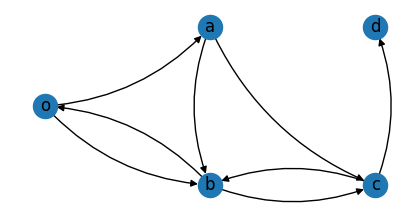

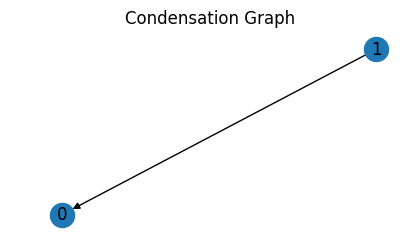

In [12]:
G2 = G.copy()
# Removing edges
edges_to_remove = [('d','a'), ('d','c')]
G2.remove_edges_from(edges_to_remove)

# Draw nodes with labels
pos = {'o': (0,0), 'a': (1,1), 'b': (1,-1), 'c': (2,-1), 'd':(2,1)}
plt.figure(figsize=(4, 2))
nx.draw(G2, pos, with_labels=True, connectionstyle='arc3, rad = 0.2')
# we use rad to adjust the curvature of the edges
# greater rad, greater the curvature of the edges
plt.show()

condensation_graph = nx.condensation(G2)
# Draw the condensation graph
plt.figure(figsize=(4,2))
print("\n")
nx.draw(condensation_graph,with_labels=True)
plt.title("Condensation Graph")
plt.show()

In [13]:
# Check if the graph is strongly connected
print("Is the graph strongly connected?", nx.is_strongly_connected(G2))

# Find the strongly connected components.
strongly_connected_components = list(nx.strongly_connected_components(G2))
print("Strongly connected components:", strongly_connected_components)

# Check if each strongly connected component is aperiodic.
for component in strongly_connected_components:
    subgraph = G2.subgraph(component)
    is_aperiodic = nx.is_aperiodic(subgraph)
    print(f"Is the subgraph aperiodic? {is_aperiodic} for nodes {component}")

Is the graph strongly connected? False
Strongly connected components: [{'d'}, {'o', 'c', 'b', 'a'}]
Is the subgraph aperiodic? False for nodes {'d'}
Is the subgraph aperiodic? True for nodes {'o', 'c', 'b', 'a'}


Removing edges $(d,a)$ and $(d,c)$, the node $d$ becomes a sink node and the asymptotic behaviour can change. To study the dynamic, a self-loop is added to the node $d$.

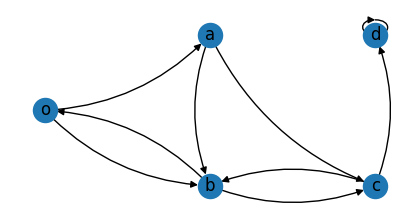

Is the graph strongly connected? False
Strongly connected components: [{'d'}, {'o', 'c', 'b', 'a'}]
Is the subgraph aperiodic? True for nodes {'d'}
Is the subgraph aperiodic? True for nodes {'o', 'c', 'b', 'a'}


In [14]:
# We add a self loop on 'd'
G2.add_edge('d','d') # to not have a singular matrix

# Draw nodes with labels
plt.figure(figsize=(4, 2))
nx.draw(G2, pos, with_labels=True, connectionstyle='arc3, rad = 0.2')
plt.show()

# Check if the graph is strongly connected
print("Is the graph strongly connected?", nx.is_strongly_connected(G2))

# Find the strongly connected components
strongly_connected_components = list(nx.strongly_connected_components(G2))
print("Strongly connected components:", strongly_connected_components)

# Check if each strongly connected component is aperiodic
for component in strongly_connected_components:
    subgraph = G2.subgraph(component)
    is_aperiodic = nx.is_aperiodic(subgraph)
    print(f"Is the subgraph aperiodic? {is_aperiodic} for nodes {component}")


Now the graph is no longer strongly connected. However, since in the graph contains only one sink (a globally reachable connected component $C_0$) represented by node $d$, we can verify the equation:
$$ \lim_{{t \to +\infty}} x_i(t) = \pi' x(0) \quad ∀_i $$

This is true because $G$ possesses a globally reachable aperiodic component $C_0$.

Thus, nodes in $C_0$ will reach separated consensus depending on their own initial conditions and we will not achieve a global consensus. In this case, consensus will depend only on $d$ and we will observe that the value converge to the one associated with $d$.

Initial condition x(0): [0.75992833 0.52871309 0.04201367 0.14049083 0.00274974]
Asymptotic value: [0.00291199 0.002888   0.00288913 0.00280412 0.00274974] 

Variance of the consensus value: 0.0783160795453664
Aalytically variance of the consensus value: 0.08333333333333333


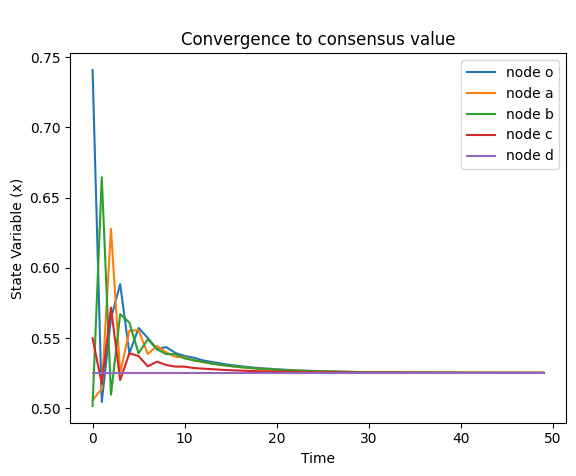

In [15]:
W = nx.adjacency_matrix(G2) # -> return type is scipy.sparse.csr_matrix
W = W.toarray() # convert W to a numpy array
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P2 = np.linalg.inv(D) @ W

# start with random initial states and run the dynamics 200 times
# store in alfa_err the consensus values at each run
alfa_err = np.zeros(200)
num_iterations = 50

# Initialize an array to store the evolution of x for each node
x_evolution = np.zeros((n_nodes, num_iterations))

# Initial conditions
x = np.random.rand(n_nodes)
print("Initial condition x(0):", x)

for i in range(num_iterations):
  x = P2 @ x
print("Asymptotic value:", x, "\n")

# Numerical simulation
for i in range(200):
  x = np.random.rand(n_nodes)
  for n in range(num_iterations):
    x = P2 @ x
    x_evolution[:, n] = x
  alfa_err[i] = (1/2 - np.mean(x))*(1/2 - np.mean(x))

print("Variance of the consensus value:", np.mean(alfa_err))

# 1/12 is the variance of a uniform distribution
print("Aalytically variance of the consensus value:", 1/12)

# Plot of the evolution of state variables for each node
labels = {node: node for node in G2.nodes()}  # to create labels
for j in range(G.number_of_nodes()):
    plt.plot(x_evolution[j, :], label='node {0:s}'.format(list(G2.nodes())[j]))

plt.legend()
plt.xlabel('Time')
plt.ylabel('State Variable (x)')
plt.title('\nConvergence to consensus value')
plt.show()

From the plot we notice that the value of the convergence depends exclusively on the initial value of the sink component (node $d$).

**(h)** Consider the graph $G = (V, E, \Lambda)$, and remove the edges $(c, b)$ and $(d, a)$.

**Analyse the French- DeGroot dynamics on the new graph. In particular, describe how the asymptotic behaviour of the dynamics varies in terms of the initial condition $x(0)$, and motivate your answer**

According to the French-DeGroot model, we need to check if the graph is strongly connected and we verify the equation
$$ \lim_{{t \to +\infty}} x_i(t) = \pi' x(0) $$
that, as we know, it is true if $G$ possesses a globally reachable aperiodic component.

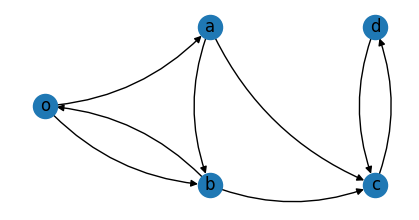

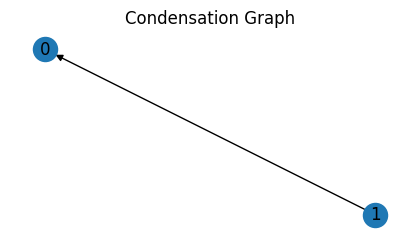

In [16]:
G3 = G.copy()
edges_to_remove = [('d','a'), ('c','b')]
G3.remove_edges_from(edges_to_remove)

Lambda2 = nx.adjacency_matrix(G3)
Lambda2 = Lambda2.toarray()

for u,v in G3.edges:
   G3[u][v]['weight'] = Lambda2[map[u]][map[v]]

plt.figure(figsize=(4, 2))
nx.draw(G3, pos, with_labels=True, connectionstyle='arc3, rad = 0.2')
plt.show()

condensation_graph = nx.condensation(G3)

# Draw condensation graph
plt.figure(figsize=(4,2))
nx.draw(condensation_graph,with_labels=True)
plt.title("Condensation Graph")
plt.show()

In [17]:
# Check if the graph is strongly connected
print("Is the graph strongly connected?", nx.is_strongly_connected(G3))

# Find the globally reachable connected components
strongly_connected_components = list(nx.strongly_connected_components(G3))
print("Strongly connected components:", strongly_connected_components)

# Check if the components are aperiodic
for component in strongly_connected_components:
    subgraph = G3.subgraph(component)
    is_aperiodic = nx.is_aperiodic(subgraph)
    print(f"Is the subgraph aperiodic? {is_aperiodic} for nodes {component}")

Is the graph strongly connected? False
Strongly connected components: [{'d', 'c'}, {'o', 'b', 'a'}]
Is the subgraph aperiodic? False for nodes {'d', 'c'}
Is the subgraph aperiodic? True for nodes {'o', 'b', 'a'}


 # Experiment  1 

Initial condition: [0.13827324 0.64993216 0.80895682 0.2048455  0.23246791] 

final opinions: [0.22010107 0.22005655 0.21252564 0.23246791 0.2048455 ] 



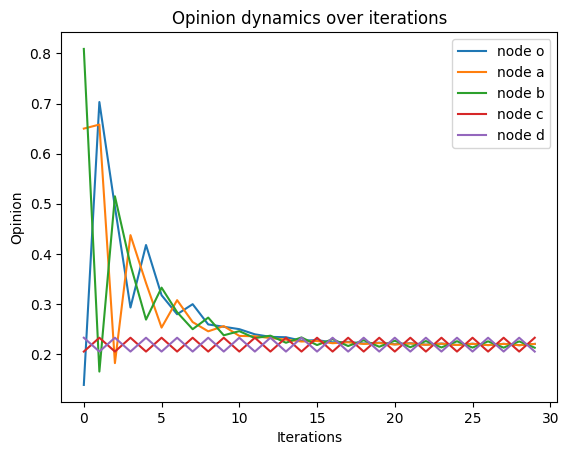

 # Experiment  2 

Initial condition: [0.54808904 0.10765531 0.79005928 0.08260019 0.14651524] 

final opinions: [0.1176937  0.11763941 0.10021211 0.14651524 0.08260019] 



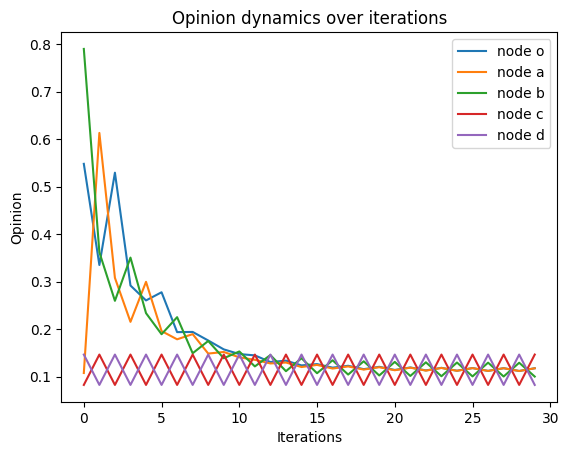

 # Experiment  3 

Initial condition: [0.68888546 0.85957418 0.07122005 0.30732766 0.65603245] 

final opinions: [0.49751936 0.49752105 0.40242027 0.65603245 0.30732766] 



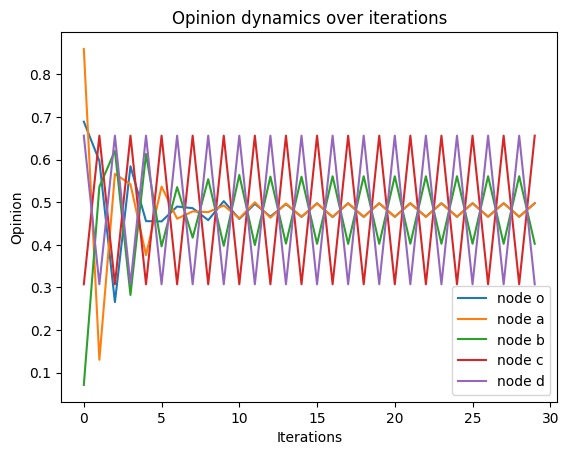

 # Experiment  4 

Initial condition: [0.38163118 0.77264422 0.60116197 0.65574862 0.01521742] 

final opinions: [0.30653033 0.30649188 0.48118455 0.01521742 0.65574862] 



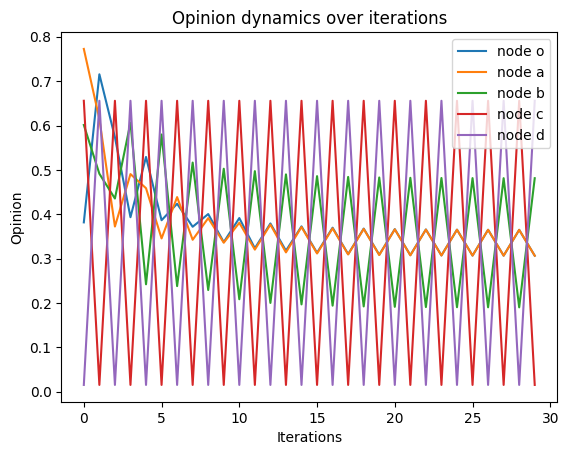

 # Experiment  5 

Initial condition: [0.36500437 0.51668729 0.47996355 0.15818279 0.60626151] 

final opinions: [0.40261338 0.40260756 0.28040465 0.60626151 0.15818279] 



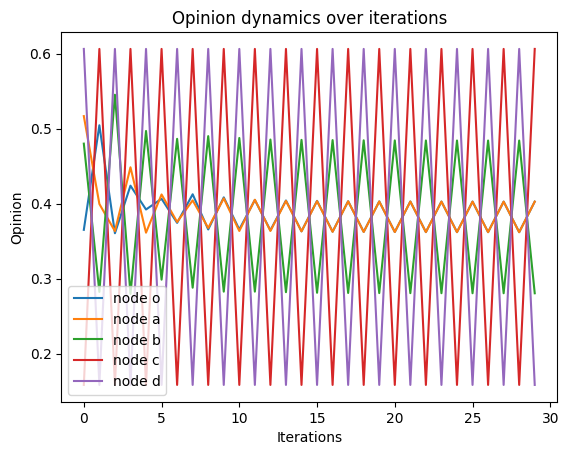

In [18]:
degrees3 = np.sum(Lambda2,axis=1)
D3 = np.diag(degrees3)
P3 = np.linalg.inv(D3) @ Lambda2

w,v = np.linalg.eig(P3.T)

# Select the eigenvalue 1 and print the eigenvector
for index in [i for i in range(len(G3)) if np.isclose(w[i],1)]:
    pi = v[:,index].real  # -> eigenvectors are complex but pi is real,
                          # so we convert it to real
    pi = pi/np.sum(pi)
    # Support of pi is different from 0 only in nodes "c" and "d" (sink)

n_iter = 30 # number of iterations among nodes
n_times = n_nodes # number of simulations for every input

for i in range(n_times):

  # Set the initial condition for the dynamics
  # Input
  x = np.zeros((n_nodes,n_iter))

  # The asymptotic behaviour of dynamics is linked with initial conditions x0
  # with the following law
  u = np.random.rand(n_nodes)
  # u = 10*np.random.rand(n_nodes)
  # u = 50*np.random.rand(n_nodes)
  # u = 100*np.random.rand(n_nodes)

  x[:,0] = u
  x0 = x[:,0]

  print(" # Experiment ",i+1,"\n")
  print("Initial condition:", x0, "\n")

  # Evolve the opinion vector
  for t in range(1, n_iter):
    x[:,t] = P3 @ x[:,t-1]
  x_final = x[:,n_iter-1]
  print("final opinions:", x_final, "\n")

  # plot to see if we reach a consensus
  for node in range(G.number_of_nodes()):
    trajectory = x[node,:]
    plt.plot(trajectory, label='node {0:s}'.format(list(G.nodes())[node]))

  plt.legend()
  plt.title("Opinion dynamics over iterations")
  plt.xlabel('Iterations')
  plt.ylabel('Opinion')
  plt.show()

In this case, even if only one sink is present, the dynamics don't converge to a single state. This is because the sink component is periodic. Consequently, inside the sink component, there will never be a convergence of opinions; instead, each node within it will retain its own opinion. This implies that nodes outside the sink component will not converge to a single value.

**Problem 2.**

In this part, with the addition of weights, we consider the network of the previous exercise with one modification. We simulate the continuous-time motion of multiple particles (no more than a single particle) from two different perspectives: the "particle perspective" and the "node perspective." We discuss Modelling Continuos time Markov Chains and the approaches to use to evolve the network.

**a) Particle perspective**

According to a "particle perspective," we could have worked in two different ways: by associating each of the particles with a Poisson clock and moving them independently or by using a single system-wide Poisson clock with an appropriate rate. The approach taken is as follows:
1. we defined a single **global** Poisson clock with an appropriate rate $\omega^* = \max_i(\omega_i)$ (where $\omega_i= \sum_j \Lambda_{ij}$) for the number of particles in the network

2. when we are at node $i$ and **the global clock ticks**, we either jump to a neighbor $j$ with probability $\bar P_{ij},i \neq j,$ or stay at the same node (no transition) with probability $\bar P_{ii} = 1 - \sum_{i \neq j} \bar P_{ij}$.

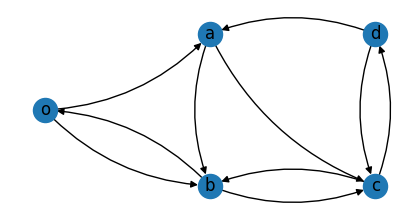

In [19]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Graph definition
G = nx.DiGraph()
G.add_nodes_from(['o','a','b','c','d'])
G.add_edges_from([('o', 'a'), ('o', 'b'),
                  ('a', 'b'), ('a', 'c'),
                  ('b', 'o'), ('b', 'c'),
                  ('c', 'b'), ('c', 'd'),
                  ('d', 'a'), ('d', 'c')])

# Transition rate matrix
Lambda = [
          [0, 2/5, 1/5, 0, 0],
          [0, 0, 3/4, 1/4, 0],
          [1/2, 0, 0, 1/3, 0],
          [0, 0, 1/3, 0, 2/3],
          [0, 1/3, 0, 1/3, 0],
]

for u,v in G.edges:
   G[u][v]['weight'] = Lambda[map[u]][map[v]]

# Draw nodes with labels
pos = {'o': (0,0), 'a': (1,1), 'b': (1,-1), 'c': (2,-1), 'd':(2,1)}
plt.figure(figsize=(4, 2))
nx.draw(G, pos, with_labels=True, connectionstyle='arc3, rad = 0.2')
# we use rad to adjust the curvature of the edges
# greater rad, greater the curvature of the edges

plt.show()

In [20]:
w = np.sum(Lambda, axis=1)
w_star = np.max(w)

# Compute the off-diagonal part of Q
P_bar = Lambda/w_star
# Add the diagonal part
P_bar = P_bar + np.diag(np.ones(len(w))-np.sum(P_bar,axis=1))

# Compute dominant eigenvector
values,vectors = np.linalg.eig(P_bar.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)

nstates = len(pi_bar)

*   If 100 particles all start in node $b$, what is the average time for a particle to return to node $b$?

The first thing to be decided is whether to simultaneously keep track of 100 particles moving through the network independently, or to move one single particle for 100 times and then calculating the average time. Both procedures should have the same result for the calculation of the average time, precisely due to the independence of the particles from each other.
Our approach, so that we would not have an almost identical solution to Problem 1, was to insert 100 particles into the ```start_node```, node $b$, keeping track of the current position of each of them (stored in the ``pos`` vector of size ``n_particles``). At the tick of the system-wide Poisson clock, a random choice occurs among all particles that have not arrived at the destination (that do not have ``flag_particle`` = 1).


Furthermore, to keep track of the number of particles that have not yet arrived at the destination, we make use of a counter called ``current_n_particles``, which is correctly updated whenever a particle arrives at the destination. Moreover, when a particle arrives at the ``end_node``, the number of particles in the network decreases by 1. Consequently, the rate (in particular the calculation of ``t_next``) of the system-wide Poisson clock changes.

In [21]:
n_particles = 100 # Number of particles
current_n_particles = n_particles # starting from n_particles in the network
n_nodes=P_bar.shape[0]

start_node = map['b']
end_node = map['b']
pos=np.ones(n_particles)*start_node # current position of every particle

flag_particles = np.zeros(n_particles)
# 1 when i-th particle is arrived to end_node
time = []
time.append(0)

#transition_times will store the time instants at which jumps/transitions happen
transition_times = []
transition_times.append(0)
old = 0

# The random time to wait for the next transition
# is drawn according to its distribution
#In the formula for t_next we use w_star, the rate of the "global" Poisson clock
# and current_n_particles, the current number of particles in the network
t_next = -np.log(np.random.rand())/(w_star * current_n_particles)

while True:
  # the next state to visit will be extracted according to the probabilities
  # stored in the row of P_bar corresponding to the current state.
  # In general, to extract a value pos[i] in (0,...,num_states-1) according to
  # the discrete distribution P_bar[pos[i-1],:]

  while True:
    selected_particle = np.random.choice(n_particles)
    while flag_particles[selected_particle] == 1:
      selected_particle = np.random.choice(n_particles)

    # save the node you are leaving
    old = int(pos[selected_particle])
    # choice the destination node for the selected_particle
    pos[selected_particle] = np.random.choice(n_nodes, p=P_bar[old,:])
    # keep choicing if the particle does not immediately leave
    # the initial start_node
    # we need this to not have a path with "no movements" from the start
    if old!=start_node or pos[selected_particle]!=start_node:
      break

  # Update transition_times
  transition_times.append(transition_times[-1] + t_next)

  # if the particle arrived to end_node
  if(pos[selected_particle]==end_node):
    # mark it arrived to end_node
    flag_particles[selected_particle] = 1
    # save the last updated transition_times
    time.append(transition_times[-1])
    # decrease current_n_particles of 1 unit
    current_n_particles -= 1
    # there are no more particles in the network
    if current_n_particles == 0:
      break

  # compute t_next on current_n_particles
  t_next = -np.log(np.random.rand())/(w_star * current_n_particles)

print("Average time from node b and return to node b:", np.sum(time)/n_particles,"s")

Average time from node b and return to node b: 4.962579817425439 s


* How does this compare to the answer in Problem 1, why?

The result we obtained is consistent with what we would have expected. In fact, making a comparison with Problem 1, in which we averaged over the calculation of random paths, we can see that the values obtained are quite close to each other. This is due to the fact that in "particle perspective" the particles are independent of each other and, as written at the beginning of the paragraph, we could have taken an approach in which we would have had one particle move at a time and obtained the same result. The key here is the independence of the particles, which guarantees us a similar result.

**b) Node perspective**

In the node perspective, the calculation of ``t_next`` may seem similar to that of the "particle perspective". Again, the choice fell on having a global Poisson clock, rather than having a Poisson clock for each node, but in this case the rate does not vary since there will always be ``n_particles`` in the network.

* If 100 particles start in node $o$, and the system is simulated for 60 time units, what is the average number of particles in the different nodes at the end of the simulation?

* Illustrate the simulation above with a plot showing the number of particles in each node during the simulation time.

In this part of Problem 2, we introduced a new variable, ``particles_per_node``, useful for knowing at the current time the number of particles in each node. Instead, to keep track of the evolution of the number of particles in the nodes during simulation time, ``dist`` was created, plotted with transition_times at the end of the code, just to have a graph over time.

As can be seen from the code, there are 2 basic choices that are made at each tick of the clock:
1. The first is the choice of the node from which to start the particle, made with a probability equal to ``p=particles_per_node/n_particles`` so that it is proportional to the number of particles per node (effectively excluding even nodes with 0 particles).
2. The second is the choice of the destination node, done as usual with a probability equal to ```p=P_bar[selected_node,:]```.

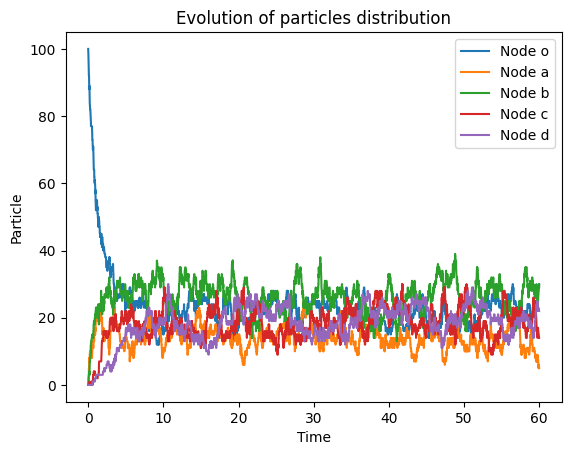


Average number of particles in the different nodes at the end of the simulation is:  [21.7  14.75 25.15 17.85 20.55]


In [22]:
n_particles = 100 # Number of particles
n_times = 20 # Number of experiments
n_nodes=P_bar.shape[0]
tot_particles_per_node = np.zeros(n_nodes)

n_steps=10000
time_units=60 # end of every simulation
stop=0

start_node = map['o']

for t in range(n_times):
  particles_per_node = np.zeros(n_nodes)
  dist = np.zeros([n_steps,n_nodes])

  pos = start_node # we have a start node
  particles_per_node[start_node] += n_particles
  dist[0] = particles_per_node

  # 'transition_times' will store the time instants at which
  # jumps/transitions happen
  transition_times = np.zeros(n_steps)

  # The random time to wait for the next transition
  # is drawn according to its distribution
  # In the formula for t_next we use w_star, the rate of the "global"
  # Poisson clock
  # and n_particles, the number of particles in the network
  t_next = -np.log(np.random.rand())/(w_star * n_particles)
  for i in range(1,n_steps):

    # Every particle makes a choice at every Poisson tick
    # p=particles_per_node/n_particles so we consider number of particles
    # in each node
    # and automatically we exclude nodes without particles
    selected_node = np.random.choice(n_nodes, p=particles_per_node/n_particles)
    pos = np.random.choice(n_nodes, p=P_bar[selected_node,:])
    # if the particle is leaving the node
    if pos != selected_node:
      particles_per_node[selected_node] -= 1
      particles_per_node[pos] += 1

    # Save the number of particles in every node at current time
    dist[i] = particles_per_node

    #Update transition_times and check if the simulation has to end (>time_units)
    transition_times[i] = transition_times[i-1] + t_next
    if transition_times[i]>=time_units:
      # save the index, we need it to plot
      stop=i
      break

    t_next = -np.log(np.random.rand())/(w_star * n_particles)

  # for the average on all simulations
  tot_particles_per_node += particles_per_node

  if t==1:
    # Plot the first simulation
    for j in G.nodes():
        plt.plot(transition_times[0:stop], dist[0:stop,map[j]], label=f'Node {j}')

    plt.xlabel('Time')
    plt.ylabel('Particle')
    plt.title('Evolution of particles distribution')
    plt.legend()
    plt.show()

print("\nAverage number of particles in the different nodes at the end of the simulation is: ", tot_particles_per_node/n_times)

* Compare the simulation result in the first point above with the stationary distribution of the continuous-time random walk followed by the single particles.

The results obtained show a more or less equal distribution among all nodes: this is due to the choice of the starting node that is made at each tick of the Poisson clock, ``selected_node``, which has a probability proportional to the number of particles per node. In the first particle perspective, on the other hand, the choice of particle was totally random and did not depend on the number of particles per node.

**Problem 3.**

The last exercise of this homework is a variation of the second one.
We have a network where a particle enters in node $o$ with a given rate, and after a certain time it gets out from the graph through the node $d$.

Our focus is to understand how the dynamics of the particles evolve over 60 units of time with different rates and a different Poisson Clock. In particular, we analyze two cases:

$a)$ Proportional Rate: the input rate is 100, and each node has a Poisson Clock proportional to the number of particles in it.

$b)$ Fixed Rate: the input rate is 1, and the Poisson clock is always the same.

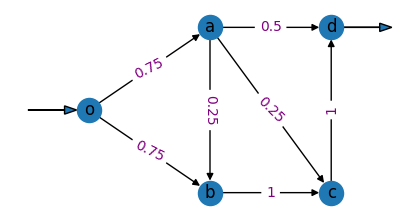

In [23]:
# Graph definition
G = nx.DiGraph()
G.add_weighted_edges_from([('o', 'a', 3/4), ('o', 'b', 3/4),
                           ('a', 'b', 1/4), ('a', 'c', 1/4), ('a', 'd', 2/4),
                           ('b', 'c', 1),
                           ('c', 'd', 1)])

# Draw nodes with labels
pos = {'o': (0,0), 'a': (1,1), 'b': (1,-1), 'c': (2,-1), 'd':(2,1)}
plt.figure(figsize=(4, 2))
nx.draw(G, pos, with_labels=True)

# Draw the incoming arrow
plt.arrow(-0.5, 0, 0.3, 0, head_width=0.1, head_length=0.1)
# Draw the outgoing arrow
plt.arrow(2, 1, 0.4, 0, head_width=0.1, head_length=0.1)

# Draw edge labels
edge_labels = {(u, v): str(G[u][v]['weight']) for u, v in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='purple')

plt.show()

In [24]:
# Transition rate matrix
Lambda_open = [
    [0, 3/4, 3/4, 0,  0 ],
    [0, 0, 1/4, 1/4, 2/4],
    [0, 0,  0,   1,   0 ],
    [0, 0,  0,   0,   1 ],
    [0, 0,  0,   0,   0 ],
]

w = np.sum(Lambda_open, axis=1)
w[map['d']] = 2
w_star = np.max(w)

# Compute the off-diagonal part of Q
P_bar = Lambda_open/w_star
# Add the diagonal part
P_bar = P_bar + np.diag(np.ones(len(w))-np.sum(P_bar,axis=1))

**a) Proportional rate**

* Simulate the system for 60 time units and plot the evolution of the number of particles in each node over time with input rate λ = 100

Particles in each node:  [32. 38. 40. 57. 19.] 



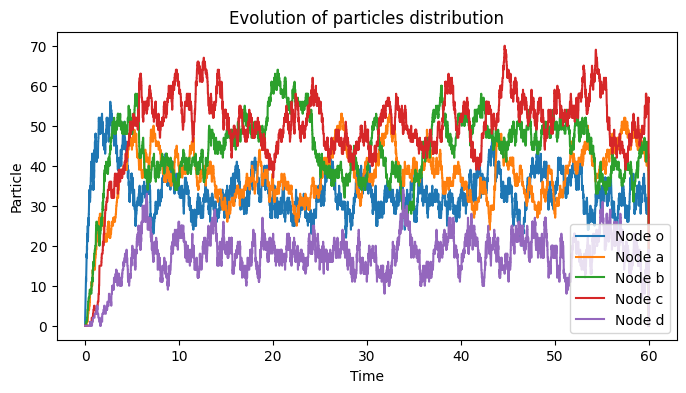

In [25]:
time_units = 60
# times is the list of time units;
# we update it at every iteration with the minimum t_next
# (so with time spent by the fastest node).
times = [0]
# t_next is the vector of the Poisson clock of the n_nodes nodes + 1
# (we consider the emission of particles as a new
# hypothetical node connected to 'o').
t_next = np.zeros(6)
input_rate = 100
n_nodes = 5
n_particles = 0
count = 1
# dist is a vector to collect the total distribution of particles in
# every time step. We use it to plot our results.
# particles_in_node is a useful structure to collect particles and
# to simulate their movement in the graph.
dist = np.zeros([150000,n_nodes])
particles_in_node = np.zeros(n_nodes)

#inizialize the Poisson clock vector
for j in range(n_nodes+1):
  if j == 0:
    #this is the rate of the particles' immission in the net,
    # this is always the same
    t_next[j] = -np.log(np.random.rand())/(input_rate)
  else:
    #at the beginning no particles in nodes
    t_next[j] = -np.log(np.random.rand())/w[j-1]

times.append(0)
ok = 1;

while times[-1] <= time_units:
# This while loop allows us to verify, at every iteration,
# whether we are selecting a node with at least one particle (to maximize
# the dynamics):
# If 'ind' is a node with more than 0 particles, we continue with the algorithm.
# If not, we set the Poisson clock of that node to 200 (in this way,
# for the current step, this node cannot be selected), and we choose another one

  while ok == 1:
    index = np.where(t_next == np.min(t_next))[0][0]
    if index != 0:
      if particles_in_node[index-1] == 0:
        t_next[index] = 200
      else:
        ok = 0
    else:
      ok = 0

  ok = 1
  #here we update time units
  times.append(times[-1] + np.min(t_next))
  #At every cycle, we need to update the Poisson Clock based on
  # the particle distribution in the graph
  for j in range(n_nodes):
# t_next[0] is always the same
# The Poisson clock is proportional to the number of particles in each node,
# so we use the following rate: particles_in_nodes * w
    if particles_in_node[j] == 0:
      t_next[j+1] = -np.log(np.random.rand())/w[j]
    else:
      t_next[j+1] = -np.log(np.random.rand())/(w[j]*particles_in_node[j])

  # After the choice of the node, we impose its correct behavior:
  # ind=1,2,3,4 -> nodes o, a, b, c: one particle is sent to another random
  # node 'pos' according to the structure of the network
  # ind=5 -> node d: one particle exits the graph, and num_particles decreases
  # otherwise, one particle enters node o
  if index == 0:
    n_particles += 1
    particles_in_node[index] += 1;
  elif index == 1 or index == 2 or index == 3 or index == 4:
    pos = np.random.choice(n_nodes, p=P_bar[index-1,:])
    if pos != index-1 :
      particles_in_node[index-1] -= 1
      particles_in_node[pos] += 1
  elif index == 5:
    if particles_in_node[index-1] > 0:
      n_particles -= 1
      particles_in_node[index-1] -= 1;

  dist[count] = particles_in_node
  count += 1

#plot the evolution of the particles' distribution
plt.figure(figsize=(8, 4))
for j in G.nodes():
    plt.plot(times, dist[0:count+1,map[j]], label=f'Node {j}')

print("Particles in each node: ", particles_in_node, "\n")

plt.xlabel('Time')
plt.ylabel('Particle')
plt.title('Evolution of particles distribution')
plt.legend()
plt.show()

The theoretical aspects of this exercise were well explained in the previous section of the homework. The only modification made was in the algorithm setup.

The crucial aspect is to synchronize the evolution of particle dynamics proportionally. Thus, we create the Poisson clock vector $t_{\text{next}}$:

The first position represents the constant rate of particle entrance into the network.
In the subsequent positions, we determine the Poisson clock for each node, where the rate is given by:

$$
t_{\text{next}_i} =
\begin{cases}
\frac{-\ln(u)}{\omega_i}, & \text{if } np_i = 0 \\
\frac{-\ln(u)}{\omega_i \cdot np_i}, & \text{otherwise}
\end{cases}
$$

where $np_i$ is the number of particles in node $i$ at time $t$.

At each operation, we identify the node $ind$ with the minimum $t_{\text{next}}$, indicating the fastest node with at least one particle (to avoid unnecessary iterations with no changes in the graph).

If the $node$ is $o$, $a$, $b$, or $c$, the particle transitions to another node, $pos$, according to the discrete distribution $\bar P$.
If the $node$ is $d$, the particle exits the graph.
Otherwise, the particle enters the graph.
Finally, we update the time variable and iterate until $time$ reaches 60 units.


**What is the largest input rate that the system can handle without blowing up?**

From the plot, we observe an equilibrium in the network regardless of the input rate. Specifically, with a proportional rate, the network speed is consistently proportional to the number of particles present. Thus, when there are few particles, more particles enter the graph. Conversely, with a higher particle count, the network accelerates, and more particles exit from node $d$.

**b) Fixed rate**

* Simulate the system for 60 time units and plot the evolution of number of particles in each node over time with input rate λ = 1

In this version, we maintain the same algorithm as before, but with a constant input rate. Additionally, the Poisson clock of each node is determined by the parameter $\omega$:
$$
t_{\text{next}_i} =
\frac{-\ln(u)}{\omega_i}
$$


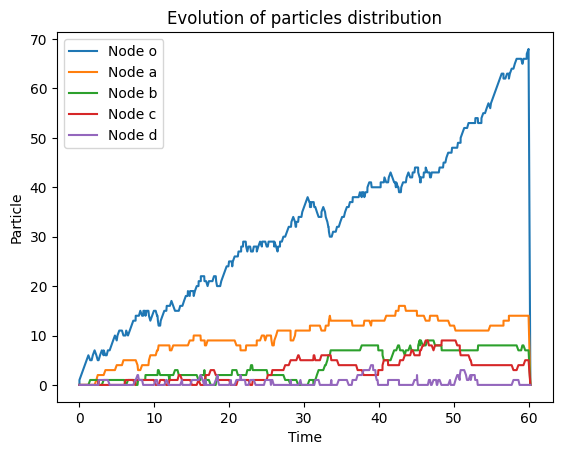

In [27]:
time_units = 60
times = [0]
t_next = np.zeros(6)

#data structures are the same of the previous point

input_rate = 2
# input_rate = 10

n_nodes = 5
n_particles = 0
count = 1
dist = np.zeros([150000,n_nodes])
particles_in_node = np.zeros(n_nodes)
for j in range(n_nodes+1):
  if j == 0:
    t_next[j] = -np.log(np.random.rand())/(input_rate)
  else:
    #rate is fixed, so we impose the same Poisson clock for every node
    t_next[j] = -np.log(np.random.rand())/w[j-1]

times.append(0)
ok = 1

#Loop until we reach 60 time units
while times[-1] <= time_units:

#This while loop allows us to enforce the selection of nodes with at
# least one particle.
  while ok == 1:
    index = np.where(t_next == np.min(t_next))[0][0]
    if index != 0:
      if particles_in_node[index-1] == 0:
        t_next[index] = 200
      else:
        ok = 0
    else:
      ok = 0
  ok = 1
  #update time units
  times.append(times[-1] + np.min(t_next))
  # If we don't want to impose conditions on the node's choice,
  # uncomment this and comment out the while loop
  # index = np.where(t_next == np.min(t_next))[0][0]

 # At every cycle, we need to update the Poisson Clock based
 # on the particle distribution in the graph
  for j in range(n_nodes):
      t_next[j+1] = -np.log(np.random.rand())/(w[j])


  # After the choice of the node, we impose its correct behavior:
  # ind=1,2,3,4 -> nodes o, a, b, c: one particle is sent to another
  # random node 'pos' according to the structure of the network
  # ind=5 -> node d: one particle exits the graph, and num_particles decreases
  # otherwise, one particle enters node o
  if index == 0:
    n_particles += 1
    particles_in_node[index] += 1;
  elif (index == 1 or index == 2 or index == 3 or index == 4) and particles_in_node[index-1] > 0:
    pos = np.random.choice(n_nodes, p=P_bar[index-1,:])
    if pos != index-1 :
      particles_in_node[index-1] -= 1
      particles_in_node[pos] += 1
  elif index == 5:
    if particles_in_node[index-1] > 0:
      n_particles -= 1
      particles_in_node[index-1] -= 1;

  dist[count] = particles_in_node
  count += 1

#plot the evolution of the particles' distribution
for j in G.nodes():
    plt.plot(times, dist[0:count+1,map[j]], label=f'Node {j}')

plt.xlabel('Time')
plt.ylabel('Particle')
plt.title('Evolution of particles distribution')
plt.legend()
plt.show()

* What is the largest input rate that the system can handle without blowing up? Motivate your answer

Following the same idea as the previous point, the final result with the fixed rate is significantly different. Indeed, in this scenario, the system can become unstable with an input rate greater than 1.

We have to consider two cases:

- If at each iteration, we don't impose the choice of a non-empty node:

  When considering λ $\leq$ 2, the minimum value of t_next at every step is always the $d$'s, allowing any particle to enter the system. The graph is a constant line at 0.

  Conversely, with λ $\gt$ 2, the lowest input rate is consistently the first. Particles enter at every iteration, and the system is unable to establish a flow throughout the entire graph. Consequently, the system becomes unstable, and all particles remain in node $o$.

- Otherwise, if we impose the choice of a node with at least one particle in it:

  When considering λ $\leq$ 1, the dynamic is stable.

  However, with λ $\gt$ 1, the behavior is more or less the same as the first case. Thus, the particle input speed becomes significantly higher than the particle sorting speed, resulting in an accumulation at node $o$.
